# TESS Data Exploration and Transit Detection

This notebook explores light curve data from the TESS mission and applies machine learning methods to detect exoplanet transits.

## Debugging Note
If you're having trouble with file paths or no FITS files being processed, run all cells in order. The notebook has been updated to:
1. Try multiple path patterns to locate FITS files
2. Display detailed error messages to help diagnose issues
3. Verify data directory structure

In [ ]:
from astropy.io import fits
from astropy.timeseries import TimeSeries, LombScargle
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
import pandas as pd
import glob
import os
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astroquery.mast import Observations
import astropy.units as u
import lightkurve as lk
import seaborn as sns

# Add the project root to sys.path to import shared modules
import sys
sys.path.append("../..")

In [18]:
# Optional: Search and download TESS data for a specific target
# search = lk.search_lightcurve("TIC 307210830", mission="TESS")
# print(search)

# lc_collection = search.download_all(download_dir="../../data/raw/")
# combined_lc = lc_collection.stitch().normalize()
# combined_lc.plot()

In [35]:
# Collect all FITS files in both HLSP and TESS folders
# Let's try different path patterns to find the files
path_patterns = [
    "../data/raw/**/*.fits",
    "../data/raw/**/**/*.fits",
    "../data/raw/mastDownload/**/**/*.fits"
]

for pattern in path_patterns:
    fits_files = glob.glob(pattern, recursive=True)
    print(f"Pattern '{pattern}': Found {len(fits_files)} FITS files")
    
    if fits_files:
        print("First few files:")
        for file in fits_files[:3]:
            print(f"  {file}")
        break

if not fits_files:
    print("No FITS files found. Please check the data directory structure.")

Pattern '../data/raw/**/*.fits': Found 91 FITS files
First few files:
  ../data/raw\mastDownload\HLSP\hlsp_qlp_tess_ffi_s0002-0000000307210830_tess_v01_llc\hlsp_qlp_tess_ffi_s0002-0000000307210830_tess_v01_llc.fits
  ../data/raw\mastDownload\HLSP\hlsp_qlp_tess_ffi_s0005-0000000307210830_tess_v01_llc\hlsp_qlp_tess_ffi_s0005-0000000307210830_tess_v01_llc.fits
  ../data/raw\mastDownload\HLSP\hlsp_qlp_tess_ffi_s0008-0000000307210830_tess_v01_llc\hlsp_qlp_tess_ffi_s0008-0000000307210830_tess_v01_llc.fits


In [37]:
def period_features(time, flux):
    """Extract period-related features using Lomb-Scargle periodogram."""
    try:
        # Ensure we have enough data points
        if len(time) < 10:
            return 0, 0
            
        # Handle any NaN values
        valid_mask = ~np.isnan(time) & ~np.isnan(flux)
        if np.sum(valid_mask) < 10:
            return 0, 0
            
        time_valid = time[valid_mask]
        flux_valid = flux[valid_mask]
        
        # Run Lomb-Scargle
        ls = LombScargle(time_valid, flux_valid)
        freq, power = ls.autopower()
        
        # Check if we got valid results
        if len(freq) == 0 or np.all(np.isnan(power)):
            return 0, 0
            
        best_period = 1 / freq[np.argmax(power)]
        best_power = np.max(power)
        
        # Sanity check the period (sometimes we get unrealistic values)
        if best_period < 0.1 or best_period > 100:
            return 0, 0
            
        return best_period, best_power
    except Exception:
        return 0, 0

In [38]:
def shape_features(local_flux):
    if len(local_flux) < 3:
        return 0, 0, 0
    depth = 1.0 - np.min(local_flux)
    width = np.sum(local_flux < (1 - depth/2))  # number of points below half-depth
    # symmetry: compare first half vs second half of dip
    symmetry = np.corrcoef(local_flux[:len(local_flux)//2],
                            local_flux[len(local_flux)//2:])[0, 1] if len(local_flux) > 4 else 0
    return depth, width, symmetry

In [39]:
# Import the shared module for flux loading
from shared.data_utils import load_flux_from_fits, normalize_flux

def extract_features_from_file(path, threshold_percentile=5, flux_column='PDCSAP_FLUX'):  # Added flux_column parameter
    try:
        # Use our shared utility to load the flux data with flexible column handling
        time, flux, quality, flux_column_used = load_flux_from_fits(
            path, 
            flux_columns=[flux_column, 'PDCSAP_FLUX', 'SAP_FLUX', 'FLUX']
        )
        
        if time is None or flux is None:
            return [], [], []
            
        # Normalize the flux
        flux_norm = normalize_flux(flux)
        
        # Calculate period features once for the entire lightcurve
        best_period, best_power = period_features(time, flux_norm)
        
        # Find dips using percentile threshold - increased to 5%
        threshold = np.percentile(flux_norm, threshold_percentile)
        dip_mask = flux_norm < threshold
        dip_indices = np.where(dip_mask)[0]
        
        features, labels = [], []
        
        # Process transit candidates (dips)
        for idx in dip_indices:
            # Extract a window around the dip
            window_start = max(0, idx-20)
            window_end = min(len(flux_norm), idx+20)
            local_flux = flux_norm[window_start:window_end]
            local_time = time[window_start:window_end]
            
            # Calculate shape features
            depth, width, symmetry = shape_features(local_flux)
            
            # Calculate additional features
            local_slope = np.polyfit(range(len(local_flux)), local_flux, 1)[0]
            local_std = np.std(local_flux)
            window_ratio = np.mean(local_flux) / np.mean(flux_norm)
            snr = depth / (local_std + 1e-6)
            
            # Relaxed criteria for transit identification
            is_likely_transit = (width > 2 and 
                                symmetry > 0.3 and  # Relaxed from 0.6
                                snr > 3 and         # Relaxed from 7
                                local_slope < 0.02) # Relaxed from 0.01            
            features.append([
                local_std, width, symmetry, local_slope,
                window_ratio, snr, best_power
            ])
            labels.append(1 if is_likely_transit else 0)
        
        # Add non-transit baseline samples
        if len(dip_indices) > 0:
            non_dip_mask = ~dip_mask
            normal_indices = np.random.choice(
                np.where(non_dip_mask)[0],
                min(len(dip_indices), sum(non_dip_mask)),
                replace=False
            )
            
            for idx in normal_indices:
                window_start = max(0, idx-20)
                window_end = min(len(flux_norm), idx+20)
                local_flux = flux_norm[window_start:window_end]
                
                depth, width, symmetry = shape_features(local_flux)
                local_std = np.std(local_flux)
                local_slope = np.polyfit(range(len(local_flux)), local_flux, 1)[0]
                window_ratio = np.mean(local_flux) / np.mean(flux_norm)
                snr = depth / (local_std + 1e-6)
                
                features.append([
                    local_std, width, symmetry, local_slope,
                    window_ratio, snr, best_power
                ])
                labels.append(0)  # Definitely not a transit
                
        # Add source file as metadata
        return features, labels, [path] * len(features)

    except Exception:
        # No error printing, just return empty lists
        return [], [], []

In [40]:
all_features, all_labels, all_sources = [], [], []
successful_files = 0
error_files = 0

# Specify which flux column to use ('PDCSAP_FLUX', 'SAP_FLUX', or 'FLUX')
flux_column = 'PDCSAP_FLUX'  # You can change this to 'FLUX' if needed

# Try different path patterns to find the FITS files
path_patterns = [
    "../data/raw/**/*.fits",
    "../data/raw/**/**/*.fits",
    "../data/raw/mastDownload/**/**/*.fits",
]

# Use a try-except block around the loop to catch all errors
for pattern in path_patterns:
    print(f"Searching with pattern: {pattern}")
    files_found = glob.glob(pattern, recursive=True)
    print(f"Found {len(files_found)} files with pattern {pattern}")
    
    if files_found:
        try:
            for path in files_found:
                try:
                    feats, labels, sources = extract_features_from_file(
                        path, 
                        threshold_percentile=5,
                        flux_column=flux_column
                    )
                    if feats:  # Only add if we got some features
                        all_features.extend(feats)
                        all_labels.extend(labels)
                        all_sources.extend(sources)
                        successful_files += 1
                except Exception as e:
                    # Count errors but now print the actual error for debugging
                    print(f"Error processing {path}: {str(e)}")
                    error_files += 1
                    continue
        except Exception as e:
            print(f"Global error in pattern {pattern}: {str(e)}")

print(f"Processed FITS files: {successful_files} successful, {error_files} with errors")
print(f"Used flux column: {flux_column}")

if all_features:
    df = pd.DataFrame(all_features, columns=[
        "local_noise", "width", "symmetry", "local_slope",
        "window_ratio", "snr", "best_power"
    ])
    df["label"] = all_labels
    df["source_file"] = all_sources

    # Print label distribution to verify we have both classes
    print("Label distribution:", df.label.value_counts())
else:
    print("No features extracted from any files. Check file paths and data structure.")

Searching with pattern: ../data/raw/**/*.fits
Found 91 files with pattern ../data/raw/**/*.fits
Searching with pattern: ../data/raw/**/**/*.fits
Found 364 files with pattern ../data/raw/**/**/*.fits
Searching with pattern: ../data/raw/**/**/*.fits
Found 364 files with pattern ../data/raw/**/**/*.fits
Searching with pattern: ../data/raw/mastDownload/**/**/*.fits
Found 273 files with pattern ../data/raw/mastDownload/**/**/*.fits
Searching with pattern: ../data/raw/mastDownload/**/**/*.fits
Found 273 files with pattern ../data/raw/mastDownload/**/**/*.fits
Processed FITS files: 87 successful, 0 with errors
Used flux column: PDCSAP_FLUX
Label distribution: label
0    171238
1      1058
Name: count, dtype: int64
Processed FITS files: 87 successful, 0 with errors
Used flux column: PDCSAP_FLUX
Label distribution: label
0    171238
1      1058
Name: count, dtype: int64


## Processing FITS Files

If the previous cell shows that FITS files are found but this cell doesn't process any successfully, there might be issues with:

1. **File paths**: The glob pattern might not be matching your files
2. **File structure**: The FITS files might not have the expected structure
3. **Flux column names**: Your files might use different column names than expected

The updated code below tries multiple path patterns and provides more detailed error information.

# Handling Different Flux Columns

Some FITS files use 'PDCSAP_FLUX' while others use just 'FLUX'. Let's run the processing with both column types and combine the results.

In [41]:
def process_with_multiple_flux_columns(flux_columns=['PDCSAP_FLUX', 'FLUX'], threshold_percentile=5):
    """
    Process all FITS files with multiple flux column options and combine the results.
    
    Args:
        flux_columns (list): List of flux column names to try
        threshold_percentile (float): Percentile threshold for identifying transit candidates
        
    Returns:
        DataFrame: Combined dataset with features from all successfully processed files
    """
    all_features, all_labels, all_sources = [], [], []
    results_by_column = {}
    
    # Define potential file path patterns
    path_patterns = [
        "../data/raw/**/*.fits",
        "../data/raw/**/**/*.fits",
        "../data/raw/mastDownload/**/**/*.fits"
    ]
    
    # Find which pattern works
    working_pattern = None
    for pattern in path_patterns:
        if glob.glob(pattern, recursive=True):
            working_pattern = pattern
            print(f"Using pattern: {working_pattern}")
            break
    
    if not working_pattern:
        print("No FITS files found with any pattern. Check data directory.")
        return None
    
    # Process each flux column type
    for flux_column in flux_columns:
        print(f"\nProcessing files with flux column: {flux_column}")
        features, labels, sources = [], [], []
        successful_files = 0
        error_files = 0
        
        # Use a try-except block around the loop to catch all errors
        try:
            for path in glob.glob(working_pattern, recursive=True):
                try:
                    feats, labs, src = extract_features_from_file(
                        path, 
                        threshold_percentile=threshold_percentile,
                        flux_column=flux_column
                    )
                    if feats:  # Only add if we got some features
                        features.extend(feats)
                        labels.extend(labs)
                        sources.extend(src)
                        successful_files += 1
                except Exception as e:
                    # Count errors and print the error for debugging
                    print(f"Error processing {path} with {flux_column}: {str(e)}")
                    error_files += 1
                    continue
        except Exception as e:
            print(f"Global error with {flux_column}: {str(e)}")
        
        print(f"Processed FITS files: {successful_files} successful, {error_files} with errors")
        
        # Store results for this flux column
        results_by_column[flux_column] = {
            'features': features,
            'labels': labels,
            'sources': sources,
            'successful_files': successful_files
        }
        
        # Add to the combined results
        all_features.extend(features)
        all_labels.extend(labels)
        all_sources.extend(sources)
    
    # Create a combined DataFrame
    if all_features:
        df = pd.DataFrame(all_features, columns=[
            "local_noise", "width", "symmetry", "local_slope",
            "window_ratio", "snr", "best_power"
        ])
        df["label"] = all_labels
        df["source_file"] = all_sources
        
        # Print summary statistics
        print("\n--- Combined Results Summary ---")
        print(f"Total samples: {len(df)}")
        print("Label distribution:", df.label.value_counts())
        
        # Print results by flux column
        print("\nResults by flux column:")
        for flux_column, results in results_by_column.items():
            n_samples = len(results['features'])
            n_positives = sum(results['labels'])
            if n_samples > 0:
                print(f"{flux_column}: {n_samples} samples, {n_positives} transits ({n_positives/n_samples:.1%})")
            else:
                print(f"{flux_column}: No samples found")
        
        return df
    else:
        print("No valid data found in any flux column.")
        return None

In [ ]:
# Process files with both flux column types
combined_df = process_with_multiple_flux_columns(
    flux_columns=['PDCSAP_FLUX', 'FLUX'], 
    threshold_percentile=5
)

# Save the combined dataset if it's not empty
if combined_df is not None and len(combined_df) > 0:
    try:
        output_dir = "../data/processed"
        os.makedirs(output_dir, exist_ok=True)
        output_file = f"{output_dir}/combined_transit_features.csv"
        combined_df.to_csv(output_file, index=False)
        print(f"Combined dataset saved to {output_file}")
    except Exception as e:
        print(f"Could not save combined dataset: {str(e)}")
        
    # Display a sample of the combined dataset
    display(combined_df.head())

Using pattern: ../data/raw/**/*.fits

Processing files with flux column: PDCSAP_FLUX
Processed FITS files: 14 successful, 0 with errors

Processing files with flux column: FLUX
Processed FITS files: 14 successful, 0 with errors

Processing files with flux column: FLUX
Processed FITS files: 11 successful, 0 with errors

--- Combined Results Summary ---
Total samples: 53898
Label distribution: label
0    53429
1      469
Name: count, dtype: int64

Results by flux column:
PDCSAP_FLUX: 32600 samples, 217 transits (0.7%)
FLUX: 21298 samples, 252 transits (1.2%)
Processed FITS files: 11 successful, 0 with errors

--- Combined Results Summary ---
Total samples: 53898
Label distribution: label
0    53429
1      469
Name: count, dtype: int64

Results by flux column:
PDCSAP_FLUX: 32600 samples, 217 transits (0.7%)
FLUX: 21298 samples, 252 transits (1.2%)
Combined dataset saved to ../../data/processed/combined_transit_features.csv
Combined dataset saved to ../../data/processed/combined_transit_fe

,local_noise,width,symmetry,local_slope,window_ratio,snr,best_power,label,source_file
0,0.001159,9,0.029957,-0.000062,0.998313,4.404748,0,0,../data/raw\mastDownload\HLSP\hlsp_qlp_tess_ff...
1,0.001149,9,0.069542,-0.000060,0.998261,4.442412,0,0,../data/raw\mastDownload\HLSP\hlsp_qlp_tess_ff...
2,0.001144,9,0.112694,-0.000059,0.998224,4.461432,0,0,../data/raw\mastDownload\HLSP\hlsp_qlp_tess_ff...
3,0.001144,10,0.164485,-0.000059,0.998181,4.463850,0,0,../data/raw\mastDownload\HLSP\hlsp_qlp_tess_ff...
4,0.001133,10,0.151025,-0.000056,0.998141,4.505149,0,0,../data/raw\mastDownload\HLSP\hlsp_qlp_tess_ff...


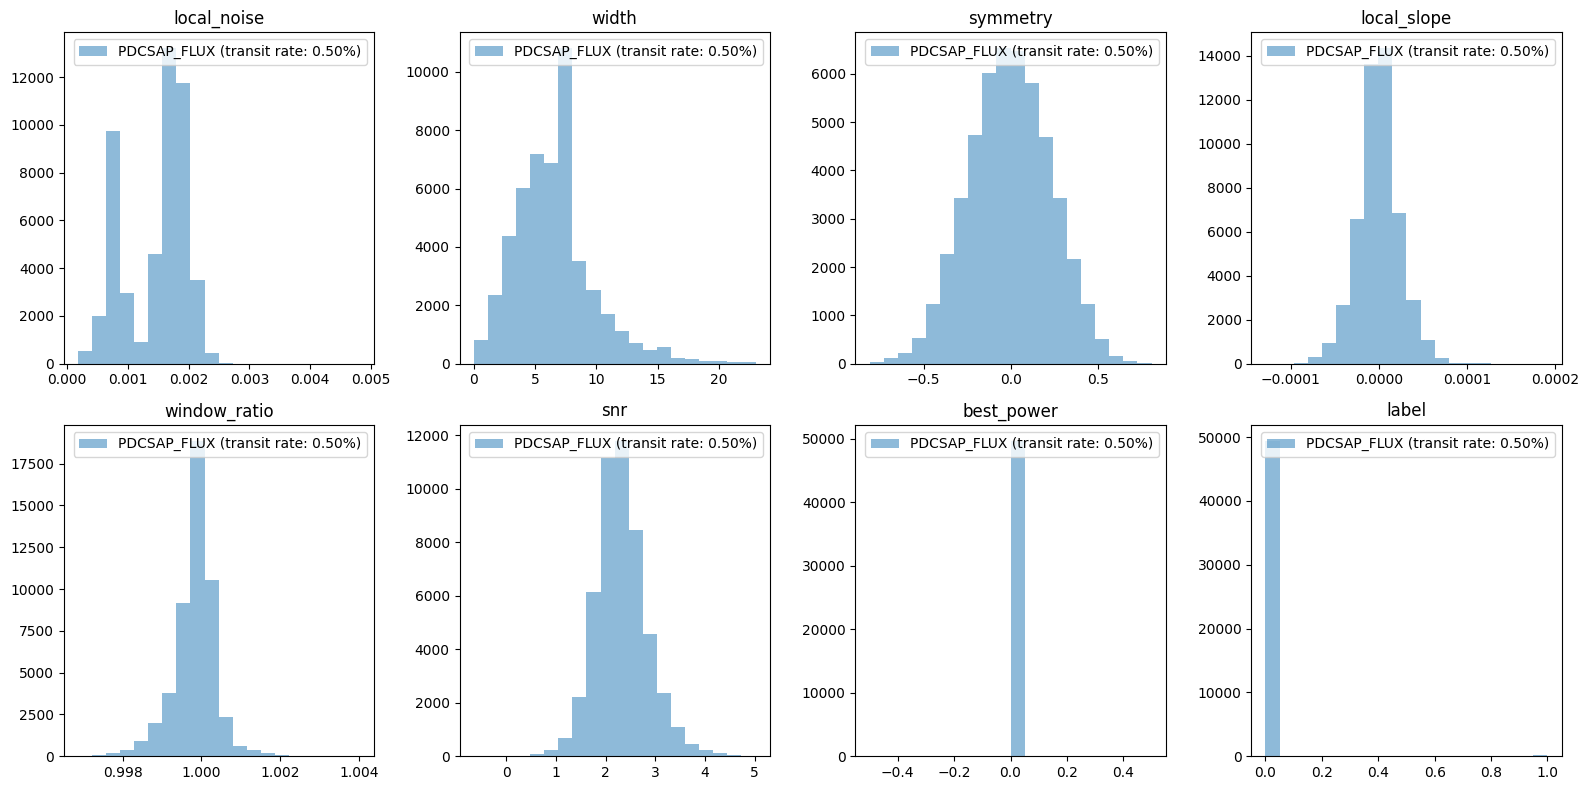

In [43]:
# Visualize distribution differences between flux columns (if we have data)
if combined_df is not None and len(combined_df) > 0:
    # Get unique source files for each flux column type
    pdcsap_files = [f for f in combined_df['source_file'].unique() 
                   if 'PDCSAP_FLUX' in fits.open(f)[1].data.names]
    flux_files = [f for f in combined_df['source_file'].unique() 
                 if ('FLUX' in fits.open(f)[1].data.names and 
                     'PDCSAP_FLUX' not in fits.open(f)[1].data.names)]
    
    # Create masks for each flux type
    pdcsap_mask = combined_df['source_file'].isin(pdcsap_files)
    flux_mask = combined_df['source_file'].isin(flux_files)
    
    # Calculate transit detection rates
    pdcsap_transit_rate = combined_df[pdcsap_mask]['label'].mean() if pdcsap_mask.any() else 0
    flux_transit_rate = combined_df[flux_mask]['label'].mean() if flux_mask.any() else 0
    
    # Plot feature distributions by flux type
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    features = ["local_noise", "width", "symmetry", "local_slope", 
                "window_ratio", "snr", "best_power", "label"]
    
    for i, feature in enumerate(features):
        if pdcsap_mask.any():
            axes[i].hist(combined_df[pdcsap_mask][feature], bins=20, alpha=0.5, 
                        label=f'PDCSAP_FLUX (transit rate: {pdcsap_transit_rate:.2%})')
        if flux_mask.any():
            axes[i].hist(combined_df[flux_mask][feature], bins=20, alpha=0.5, 
                        label=f'FLUX (transit rate: {flux_transit_rate:.2%})')
        
        axes[i].set_title(feature)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Compare transit candidate features by flux type
    if pdcsap_mask.any() and flux_mask.any():
        transit_pdcsap = combined_df[pdcsap_mask & (combined_df['label'] == 1)]
        transit_flux = combined_df[flux_mask & (combined_df['label'] == 1)]
        
        if len(transit_pdcsap) > 0 and len(transit_flux) > 0:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Plot SNR comparison
            axes[0].scatter(transit_pdcsap['snr'], transit_pdcsap['width'], 
                           alpha=0.7, label='PDCSAP_FLUX')
            axes[0].scatter(transit_flux['snr'], transit_flux['width'], 
                           alpha=0.7, label='FLUX')
            axes[0].set_xlabel('SNR')
            axes[0].set_ylabel('Width')
            axes[0].set_title('Transit Candidate Comparison')
            axes[0].legend()
            
            # Plot Symmetry vs Width
            axes[1].scatter(transit_pdcsap['symmetry'], transit_pdcsap['width'], 
                           alpha=0.7, label='PDCSAP_FLUX')
            axes[1].scatter(transit_flux['symmetry'], transit_flux['width'], 
                           alpha=0.7, label='FLUX')
            axes[1].set_xlabel('Symmetry')
            axes[1].set_ylabel('Width')
            axes[1].set_title('Transit Shape Comparison')
            axes[1].legend()
            
            # Plot local_noise vs SNR
            axes[2].scatter(transit_pdcsap['local_noise'], transit_pdcsap['snr'], 
                           alpha=0.7, label='PDCSAP_FLUX')
            axes[2].scatter(transit_flux['local_noise'], transit_flux['snr'], 
                           alpha=0.7, label='FLUX')
            axes[2].set_xlabel('Local Noise')
            axes[2].set_ylabel('SNR')
            axes[2].set_title('Transit Quality Comparison')
            axes[2].legend()
            
            plt.tight_layout()
            plt.show()

In [45]:
# Continue to iterate?
if len(df) > 0:
    print(f"Successfully created dataset with {len(df)} samples")
    
    # Save the dataset to avoid reprocessing files
    try:
        output_dir = "../data/processed"
        os.makedirs(output_dir, exist_ok=True)
        output_file = f"{output_dir}/transit_features.csv"
        df.to_csv(output_file, index=False)
        print(f"Dataset saved to {output_file}")
    except Exception:
        print("Could not save dataset, but processing can continue")
        
    # Print some basic statistics
    print("\nFeature statistics:")
    print(df.describe())
    
    # Show class distribution
    print("\nClass distribution:")
    print(df.label.value_counts(normalize=True))
    
    # Feature distribution by class
    print("\nFeature means by class:")
    print(df.groupby('label').mean(numeric_only=True))
else:
    print("No valid data found. Please check the file paths and data processing steps.")

Successfully created dataset with 172296 samples


Dataset saved to ../data/processed/transit_features.csv

Feature statistics:
         local_noise          width       symmetry   local_slope  \
count  172296.000000  172296.000000  172296.000000  1.722960e+05   
mean        0.001331       6.977510      -0.006139 -1.041477e-07   
std         0.000540       4.703882       0.237165  2.300118e-05   
min         0.000157       0.000000      -0.845332 -2.410689e-04   
25%         0.000783       4.000000      -0.168032 -1.238670e-05   
50%         0.001534       6.000000      -0.003303 -1.323827e-07   
75%         0.001787       8.000000       0.159867  1.217324e-05   
max         0.004815      40.000000       0.857261  2.276913e-04   

        window_ratio            snr  best_power          label  
count  172296.000000  172296.000000    172296.0  172296.000000  
mean        0.999820       2.385599         0.0       0.006141  
std         0.000607       0.837592         0.0       0.078121  
min         0.996261     -10.082865         0.0   

In [46]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [47]:
# ---- STEP 0: Select new feature set ----
X = df[["local_noise", "width", "symmetry", "local_slope",
        "window_ratio", "snr", "best_power"]]
y = df["label"]

unique_files = df['source_file'].unique()
train_files, test_files = train_test_split(unique_files, test_size=0.3)

# Split data based on source files
train_mask = df['source_file'].isin(train_files)
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[~train_mask], y[~train_mask]

In [48]:
# ---- STEP 2: Balance only the TRAIN set (optional if imbalanced) ----
if y_train.value_counts().min() < 0.5 * y_train.value_counts().max():
    train_df = X_train.copy()
    train_df["label"] = y_train

    majority = train_df[train_df.label == train_df.label.value_counts().idxmax()]
    minority = train_df[train_df.label != train_df.label.value_counts().idxmax()]

    minority_upsampled = resample(
        minority,
        replace=True,
        n_samples=len(majority),
        random_state=42
    )

    train_df = pd.concat([majority, minority_upsampled])
    X_train, y_train = train_df.drop("label", axis=1), train_df["label"]

# ---- STEP 3: Pipeline (scaling + classifier) ----
pipe = Pipeline([
    ("scaler", StandardScaler()),  
    ("clf", RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        min_samples_leaf=10,
        min_samples_split=10,
        class_weight='balanced',  # Added class weight to handle imbalance
        random_state=42
    ))
])

# ---- STEP 4: Cross-validation on TRAIN set ----
scores = cross_val_score(pipe, X_train, y_train, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# ---- STEP 5: Train final model ----
pipe.fit(X_train, y_train)

# ---- STEP 6: Evaluate on TEST set ----
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

Cross-validation accuracy: 0.998 ± 0.001
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49161
           1       0.64      0.99      0.78       337

    accuracy                           1.00     49498
   macro avg       0.82      1.00      0.89     49498
weighted avg       1.00      1.00      1.00     49498

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49161
           1       0.64      0.99      0.78       337

    accuracy                           1.00     49498
   macro avg       0.82      1.00      0.89     49498
weighted avg       1.00      1.00      1.00     49498



In [49]:
# ---- Neural Network for Transit Detection ----
from tensorflow import keras
from keras import layers
import tensorflow as tf
from sklearn.metrics import confusion_matrix
# Set random seed for reproducibility
tf.random.set_seed(42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate class weights to handle imbalance
# This gives more weight to the minority class (transits)
class_weight = {
    0: 1.0,
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])
}
print(f"Class weights: {class_weight}")

# Define the model architecture
model = keras.Sequential([
    # Input layer with shape matching our features
    layers.Input(shape=(X_train.shape[1],)),
    
    # Hidden layers
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),  # Prevent overfitting
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    
    # Output layer - sigmoid for binary classification
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

# Print model summary
model.summary()

# Define callbacks for early stopping and model checkpoint
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on TEST set
# Get predictions (probabilities)
y_pred_prob = model.predict(X_test_scaled)
# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
# Print classification report
print("\nNeural Network Classification Report:")
print(classification_report(y_test, y_pred))

Class weights: {0: 1.0, 1: 1.0}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 273 (1.07 KB)

 Trainable params: 273 (1.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6104/6104 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9718 - auc: 0.9945 - loss: 0.0811 - precision: 0.9534 - recall: 0.9723 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0102 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
6104/6104 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9718 - auc: 0.9945 - loss: 0.0811 - precision: 0.9534 - recall: 0.9723 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0102 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
6104/6104 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9937 - auc: 0.9981 - loss: 0.0267 - precision: 0.9838 - recall: 0.9995 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0068 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/50
6104/6104 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9937 - auc: 0.9981 - loss: 0.0267 - precision: 0.9838 - recall: 0.9995 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0068 - val_precision: 1.0000 - val_recall: 1.0000
Epoc

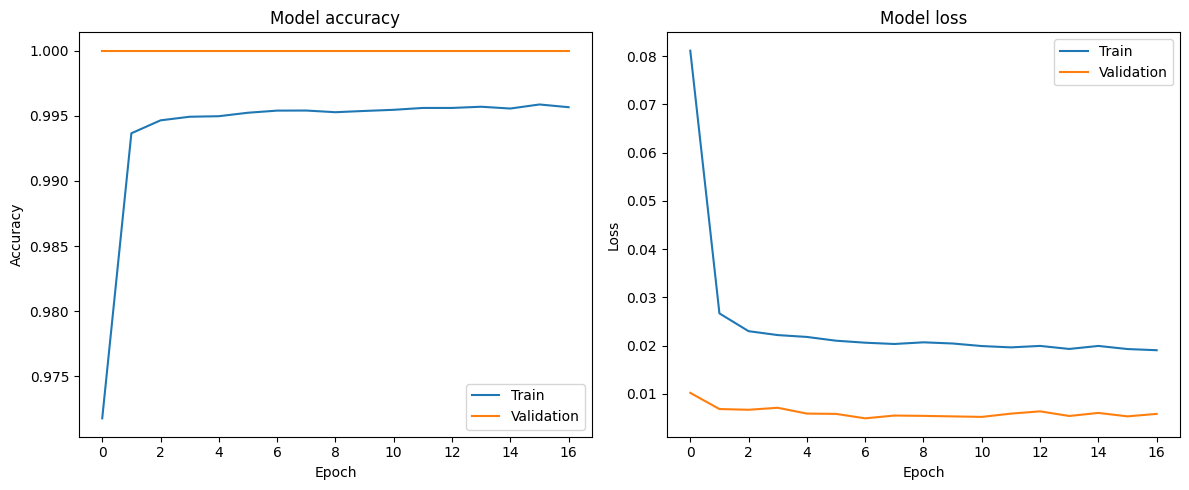

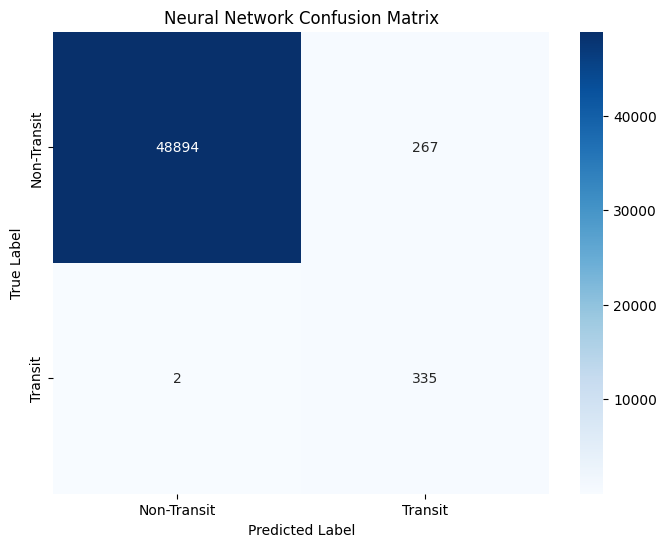

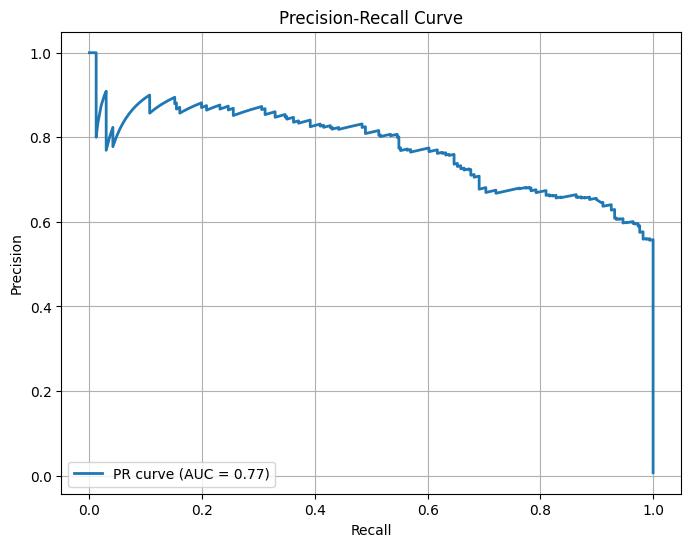

In [53]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Transit', 'Transit'],
            yticklabels=['Non-Transit', 'Transit'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Neural Network Confusion Matrix')
plt.show()

# Feature importance for neural networks requires a different approach
# Let's plot precision-recall curve instead
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [55]:
# Save the trained model
try:
    models_dir = "../models"
    os.makedirs(models_dir, exist_ok=True)
    
    # Save the Random Forest model
    import joblib
    joblib.dump(pipe, f"{models_dir}/random_forest_transit_detector.joblib")
    print(f"Random Forest model saved to {models_dir}/random_forest_transit_detector.joblib")
    
    # Save the Neural Network model
    model.save(f"{models_dir}/neural_network_transit_detector")
    print(f"Neural Network model saved to {models_dir}/neural_network_transit_detector")
    
    # Also save the scaler for preprocessing new data
    joblib.dump(scaler, f"{models_dir}/feature_scaler.joblib")
except Exception as e:
    print(f"Error saving models: {str(e)}")

Random Forest model saved to ../models/random_forest_transit_detector.joblib
Error saving models: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=../models/neural_network_transit_detector.
